# Plot Fisher information

Johann Brehmer, Kyle Cranmer, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

import madminer.core
from madminer.plotting import plot_fisher_information_contours_2d

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')

In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma/'
result_dir = base_dir + 'data/results/wgamma/'

## Load Fisher information results

In [7]:
def load_data(ml_prefix = ''):
    infos  = [np.load(result_dir + 'information_xsec_tight.npy')]
    covs   = [np.load(result_dir + 'information_covariance_xsec_tight.npy')]
    labels = ['xsec']
    colors = ['0.5']
    lss    = ['-']
    
    histo_filenames = ['met', 'ptl', 'pta', 'deltaphi_lv', 'deltaphi_la', 'phi_resurrection']
    histo_labels    = ['MET', r'$p_{T,\ell}$', r'$p_{T,\gamma}$', r'$\Delta\phi_{\ell\nu}$', r'$\Delta\phi_{\ell\gamma}$', r'$\varphi$']
    histo_colors    = ['dodgerblue', 'deepskyblue', 'steelblue', 'mediumblue', 'cornflowerblue', 'b']
    histo_lss       = ['--', '-.', ':']*2

    for hfilename, hlabel, hcolor, hls in zip(histo_filenames, histo_labels, histo_colors, histo_lss):
        infos.append(
            np.load(result_dir + 'information_histo_{}_tight.npy'.format(hfilename))
        )
        covs.append(
            np.load(result_dir + 'information_covariance_histo_{}_tight.npy'.format(hfilename))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    ml_filenames = ['full', 'full', 'resurrection']
    ml_labels    = ['full', 'full (cuts)', r'$\varphi$']
    ml_colors    = ['#CC002E', 'orangered', 'firebrick', 'r', 'lightcoral', 'lightsalmon', 'chocolate']
    ml_lss       = ['-']*2 + ['--', '-.', ':']*2
    tight_prefixes = [''] + ['_tight' for _ in ml_filenames]
    

    for hfilename, hlabel, hcolor, hls, tight_prefix in zip(ml_filenames, ml_labels, ml_colors, ml_lss, tight_prefixes):
        infos.append(
            np.load(result_dir + 'information_mean_{}{}{}.npy'.format(hfilename, tight_prefix, ml_prefix))
        )
        covs.append(
            np.load(result_dir + 'information_covariance_{}{}{}.npy'.format(hfilename, tight_prefix, ml_prefix))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    return infos, covs, labels, colors, lss


In [12]:
infos, covs, labels, colors, lss = load_data('')

for i, label in enumerate(labels):
    print(i, label)

0 xsec
1 MET
2 $p_{T,\ell}$
3 $p_{T,\gamma}$
4 $\Delta\phi_{\ell\nu}$
5 $\Delta\phi_{\ell\gamma}$
6 $\varphi$
7 full
8 full (cuts)
9 $\varphi$


## Plotting function

In [8]:
def make_plot(ml_prefix = '', indices=None, xmax=0.05):
    infos, covs, labels, colors, lss = load_data(ml_prefix)
    
    if indices is not None:
        infos = [infos[i] for i in indices]
        covs = [covs[i] for i in indices]
        labels = [labels[i] for i in indices]
        colors = [colors[i] for i in indices]
        lss = [lss[i] for i in indices]

    fig = plot_fisher_information_contours_2d(
        fisher_information_matrices=infos,
        fisher_information_covariances=covs,
        contour_distance=1.,
        xrange=(-xmax,xmax),
        yrange=(-xmax,xmax),
        xlabel=r'$f_{WWW}$',
        ylabel=r'$f_{\tilde{W}WW}$',
        linestyles=lss,
        colors=colors,
        resolution=600,
        inline_labels=labels
    )
    
    return fig


## Plots

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


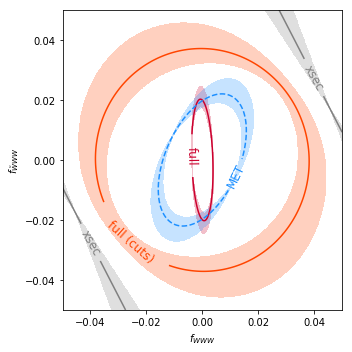

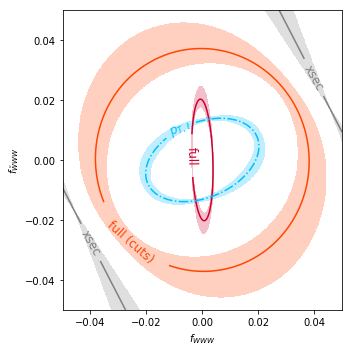

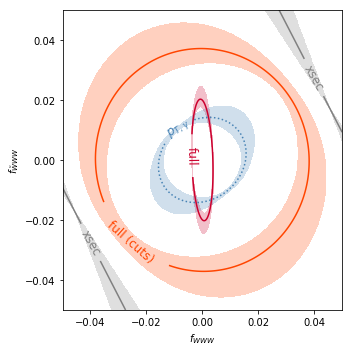

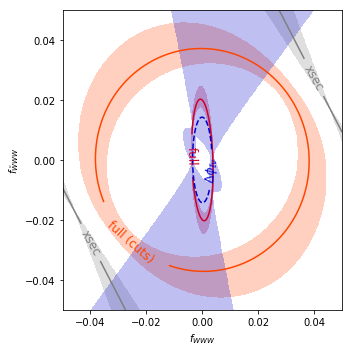

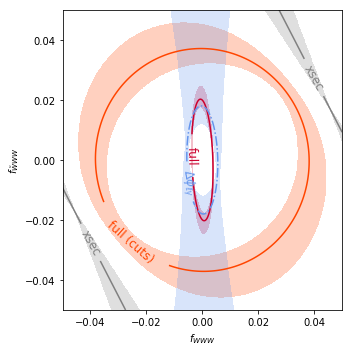

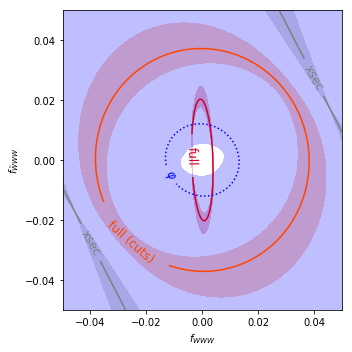

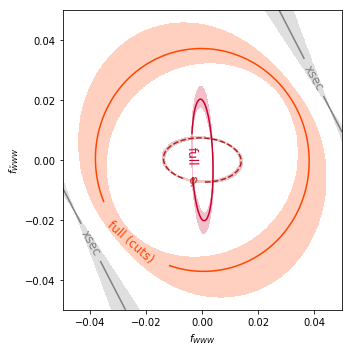

In [18]:
for i in [1,2,3,4,5,6,9]:
    fig = make_plot('', [0,7,8, i])
